In [1]:
import pandas as pd
import opencc
import csv
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
df_male = pd.read_csv("data/1976_raw_male.csv")
df_female = pd.read_csv("data/1976_raw_female.csv")
df_neutral = pd.read_csv("data/1976_raw_neutral.csv")

In [3]:
# Length
print(f"Male: {len(df_male)}")
print(f"Female: {len(df_female)}")
print(f"Neutral: {len(df_neutral)}")

Male: 789
Female: 1113
Neutral: 666


In [4]:
# Add gender column
df_male['gender'] = 'male'
df_female['gender'] = 'female'
df_neutral['gender'] = 'neutral'

In [5]:
# Merge
df = pd.concat([df_male, df_female, df_neutral], ignore_index=True)

In [6]:
# Translate
converter = opencc.OpenCC('t2s.json')
for col in df.columns:
    if col == 'detail_url':
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: converter.convert(x) if isinstance(x, str) else x)

In [7]:
# Clean description
if 'description' in df.columns:
    df['description'] = df['description'].replace({r'\r\n|\n|\r': ''}, regex=True)

In [8]:
# Drop null fragrance and notes
print(df[['fragrance', 'top_notes', 'middle_notes', 'base_notes']].isna().sum())
df = df.dropna(subset=['fragrance', 'top_notes', 'middle_notes', 'base_notes'])

fragrance       110
top_notes       155
middle_notes    301
base_notes      314
dtype: int64


In [9]:
# Remove spaces
for col in ['fragrance', 'top_notes', 'middle_notes', 'base_notes']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [10]:
# Keep the first fragrance as the main one
df['fragrance'] = df['fragrance'].apply(lambda x: x.split('、')[0] if isinstance(x, str) else x)

In [11]:
# Count notes
note_columns = ['top_notes', 'middle_notes', 'base_notes']
note_counts = {}

for col in note_columns:
  if col in df.columns:
    for s in df[col]:
      if isinstance(s, str):
        for item in [n.strip() for n in s.split('、') if n.strip()]:
          note_counts[item] = note_counts.get(item, 0) + 1

# Save
with open('data/ntoe_count.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  writer.writerow(['note', 'count'])
  for item, count in sorted(note_counts.items(), key=lambda x: x[1], reverse=True):
    writer.writerow([item, count])


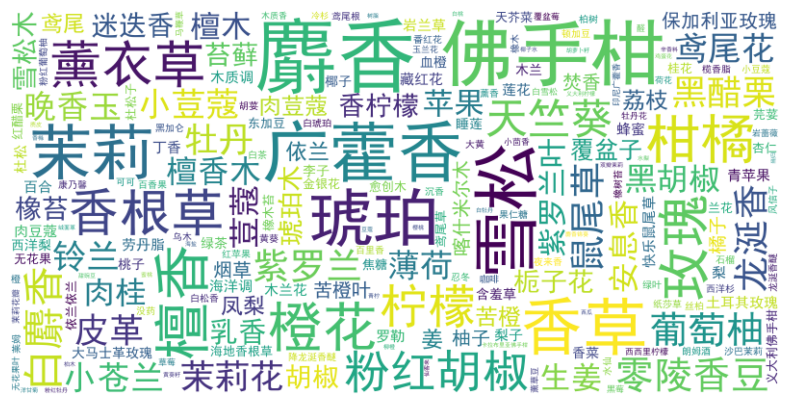

In [12]:
# Word Cloud
wc = WordCloud(font_path='simhei.ttf', width=800, height=400, background_color='white')
wc.generate_from_frequencies(note_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# Count fragrance
fragrance_counts = {}
for s in df['fragrance']:
    for item in [i.strip() for i in s.split('、') if i.strip()]:
        fragrance_counts[item] = fragrance_counts.get(item, 0) + 1

# Save
with open('data/fragrance_count.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['fragrance', 'count'])
    for item, count in sorted(fragrance_counts.items(), key=lambda x: x[1], reverse=True):
        writer.writerow([item, count])

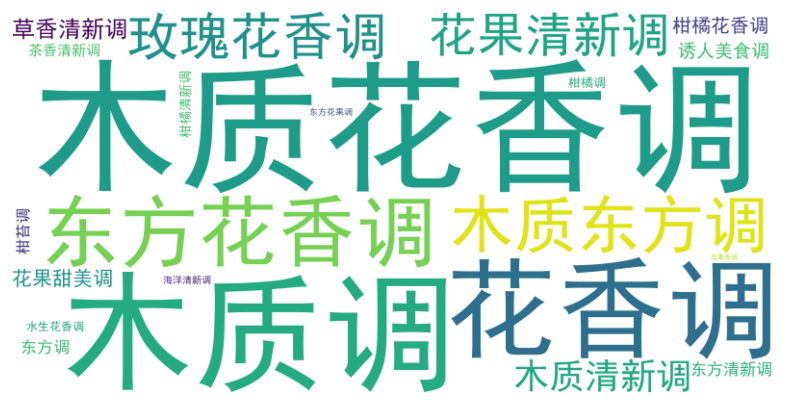

In [14]:
# word cloud
wc = WordCloud(font_path='simhei.ttf', width=800, height=400, background_color='white')
wc.generate_from_frequencies(fragrance_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
# Fragrance mapping to categories
df = df.rename(columns={'fragrance': 'original_fragrance'})
map_fragrance = pd.read_csv("data/fragrance_map.csv")
df = df.merge(map_fragrance, how='left', left_on='original_fragrance', right_on='original_fragrance')

In [16]:
# def combine_notes(row):
#     top = row['top_notes'] if isinstance(row['top_notes'], str) else ''
#     middle = row['middle_notes'] if isinstance(row['middle_notes'], str) else ''
#     base = row['base_notes'] if isinstance(row['base_notes'], str) else ''
#     return f"前调：{top}；中调：{middle}；后调：{base}"

# df['notes_list'] = df.apply(combine_notes, axis=1)

In [17]:
df.to_csv("data/1976_clean.csv",index=False)